In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
import cv2
import pandas as pd

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('.'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, '.')

from models.grid_proto_fewshot import FewShotSeg

%matplotlib inline
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

/mnt/hdd2t/miniconda3/envs/UniverSeg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 1.13.1+cu116
CUDA available: True


## 1. Configuration

In [2]:
# ================= CONFIG =================
# Dataset paths
DATA_ROOT = "/thiends/hdd2t/UniverSeg/OTU_2D"  # Adjust to your actual path
TRAIN_IMAGES = os.path.join(DATA_ROOT, "train1/Image/")
TRAIN_LABELS = os.path.join(DATA_ROOT, "train1/Label/")
VAL_IMAGES = os.path.join(DATA_ROOT, "validation1/Image/")
VAL_LABELS = os.path.join(DATA_ROOT, "validation1/Label/")
TRAIN_TXT = os.path.join(DATA_ROOT, "train.txt")
VAL_TXT = os.path.join(DATA_ROOT, "val.txt")
TRAIN_CLS = os.path.join(DATA_ROOT, "train_cls.txt")
VAL_CLS = os.path.join(DATA_ROOT, "val_cls.txt")

# Model paths - UPDATE THIS TO YOUR TRAINED MODEL
MODEL_PATH = "./runs/mySSL_CHAOST2_Superpix_sets_0_1shot/1/snapshots/100000.pth"  # Example path

# Image settings
RESIZE_TO = (256, 256)  # SSL_ALPNet uses 256x256
INPUT_SIZE = (256, 256)

# Model settings
MODEL_CONFIG = {
    'align': True,
    'use_coco_init': True,
    'which_model': 'dlfcn_res101',
    'cls_name': 'grid_proto',
    'proto_grid_size': 8,
    'feature_hw': [32, 32],
    'reload_model_path': None
}

# Evaluation settings
NUM_CLASSES = 8
LABEL_NAMES = [f"Class {i}" for i in range(NUM_CLASSES)]
VAL_WSIZE = 2  # Validation window size for prototype pooling
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {DEVICE}")
print(f"Data root: {DATA_ROOT}")
print(f"Image size: {RESIZE_TO}")

Device: cuda
Data root: /thiends/hdd2t/UniverSeg/OTU_2D
Image size: (256, 256)


## 2. Data Loading Utilities

In [3]:
def load_cls_labels(filepath):
    """Load class labels from txt file"""
    labels = {}
    with open(filepath) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                filename = parts[0].replace('.JPG', '')
                cls = int(parts[1])
                labels[filename] = cls
    return labels

def process_image(image_path, resize_to, tile_z=3):
    """
    Load and preprocess image for SSL_ALPNet
    - Converts to RGB
    - Resizes to target size
    - Normalizes to [0, 1]
    - Returns [3, H, W] tensor
    """
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(resize_to, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        # Normalize per-image (similar to MR normalization)
        img = (img - img.mean()) / (img.std() + 1e-8)
        return np.transpose(img, (2, 0, 1))  # [3, H, W]
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def process_mask(mask_path, resize_to):
    """
    Load mask and binarize: pixel > 0 → 1.0, pixel = 0 → 0.0
    """
    try:
        mask = Image.open(mask_path).convert('L')
        mask = mask.resize(resize_to, Image.NEAREST)
        mask = np.array(mask, dtype=np.float32)
        # Binary mask
        mask = (mask > 0).astype(np.float32)
        return mask
    except Exception as e:
        print(f"Error loading mask {mask_path}: {e}")
        return None

# Test image loading
print("Testing image loading...")
if os.path.exists(TRAIN_LABELS):
    test_mask_files = os.listdir(TRAIN_LABELS)
    if test_mask_files:
        test_mask_path = os.path.join(TRAIN_LABELS, test_mask_files[0])
        test_mask = process_mask(test_mask_path, RESIZE_TO)
        print(f"   Mask path: {test_mask_path}")
        print(f"   Mask unique values: {np.unique(test_mask)}")
        print(f"   Mask shape: {test_mask.shape}")
        print("   ✅ Mask loading OK!")
else:
    print(f"   ❌ TRAIN_LABELS path not found: {TRAIN_LABELS}")

Testing image loading...
   Mask path: /thiends/hdd2t/UniverSeg/OTU_2D/train1/Label/1279.PNG
   Mask unique values: [0. 1.]
   Mask shape: (256, 256)
   ✅ Mask loading OK!


In [4]:
class OTU2DDataset:
    """
    OTU2D Dataset loader for SSL_ALPNet evaluation
    """
    def __init__(self, images_dir, labels_dir, ids_file, cls_labels, resize_to=RESIZE_TO):
        self.samples = []
        self.cls_labels = cls_labels
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.resize_to = resize_to
        self.samples_by_class = defaultdict(list)

        print("=" * 70)
        print(f"Loading OTU2DDataset from {os.path.basename(images_dir)}...")
        print("=" * 70)

        with open(ids_file, 'r') as f:
            ids = [line.strip() for line in f if line.strip()]

        for idx, id_ in enumerate(ids):
            img_name = f"{id_}.JPG"
            mask_name = f"{id_}.PNG"
            img_path = os.path.join(images_dir, img_name)
            mask_path = os.path.join(labels_dir, mask_name)

            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue

            cls = self.cls_labels.get(id_, None)
            if cls is None:
                continue

            img = process_image(img_path, resize_to)
            if img is None:
                continue

            mask = process_mask(mask_path, resize_to)
            if mask is None:
                continue

            if np.sum(mask) < 1:  # Skip if no significant mask
                continue

            sample = {
                'image': img,
                'mask': mask,
                'class': cls,
                'img_path': img_path,
                'id': id_
            }
            self.samples.append(sample)
            self.samples_by_class[cls].append(len(self.samples) - 1)

        print(f"Loaded {len(self.samples)} valid samples.")
        print(f"Class distribution:")
        for cls in sorted(self.samples_by_class.keys()):
            print(f"  Class {cls}: {len(self.samples_by_class[cls])} samples")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]
    
    def get_samples_by_class(self, cls):
        """Get all sample indices for a specific class"""
        return self.samples_by_class.get(cls, [])

In [5]:
# Load datasets
train_cls_labels = load_cls_labels(TRAIN_CLS)
val_cls_labels = load_cls_labels(VAL_CLS)

support_pool = OTU2DDataset(TRAIN_IMAGES, TRAIN_LABELS, TRAIN_TXT, train_cls_labels, RESIZE_TO)
test_set = OTU2DDataset(VAL_IMAGES, VAL_LABELS, VAL_TXT, val_cls_labels, RESIZE_TO)

print(f"\n📊 Dataset Summary:")
print(f"   Support pool: {len(support_pool)} samples")
print(f"   Test set: {len(test_set)} samples")

Loading OTU2DDataset from ...
Loaded 1000 valid samples.
Class distribution:
  Class 0: 226 samples
  Class 1: 153 samples
  Class 2: 228 samples
  Class 3: 57 samples
  Class 4: 47 samples
  Class 5: 180 samples
  Class 6: 71 samples
  Class 7: 38 samples
Loading OTU2DDataset from ...
Loaded 469 valid samples.
Class distribution:
  Class 0: 110 samples
  Class 1: 66 samples
  Class 2: 108 samples
  Class 3: 31 samples
  Class 4: 19 samples
  Class 5: 87 samples
  Class 6: 33 samples
  Class 7: 15 samples

📊 Dataset Summary:
   Support pool: 1000 samples
   Test set: 469 samples


## 3. Load SSL_ALPNet Model

In [6]:
def load_model(model_path=None, config=MODEL_CONFIG):
    """
    Load SSL_ALPNet model (FewShotSeg)
    """
    print("Loading SSL_ALPNet model...")
    
    model = FewShotSeg(pretrained_path=model_path, cfg=config)
    model = model.to(DEVICE)
    model.eval()
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"   ✅ Model loaded successfully!")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    
    return model

# Load model
# Option 1: Load pretrained weights
# model = load_model(MODEL_PATH, MODEL_CONFIG)

# Option 2: Use COCO-initialized model (no finetuning)
model = load_model(None, MODEL_CONFIG)

print(f"\nModel is on: {next(model.parameters()).device}")

Loading SSL_ALPNet model...


/mnt/hdd2t/miniconda3/envs/UniverSeg/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/hdd2t/miniconda3/envs/UniverSeg/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


###### NETWORK: Using ms-coco initialization ######
   ✅ Model loaded successfully!
   Total parameters: 59,214,912
   Trainable parameters: 59,214,912

Model is on: cuda:0


## 4. Inference Utilities

In [7]:
def prepare_support_data(support_samples, target_class):
    """
    Prepare support images and masks for SSL_ALPNet
    
    SSL_ALPNet expects:
    - supp_imgs: way x shot x [B x 3 x H x W], list of lists of tensors
    - fore_mask: way x shot x [B x H x W], list of lists of tensors  
    - back_mask: way x shot x [B x H x W], list of lists of tensors
    
    After torch.stack in model: [Wa, Sh, B, H, W]
    """
    support_images = []
    support_fg_masks = []
    support_bg_masks = []
    
    for sample in support_samples:
        # Image: [1, 3, H, W]
        img = torch.from_numpy(sample['image']).float().unsqueeze(0).to(DEVICE)
        
        # Mask: [H, W] -> [1, H, W] for [B, H, W] format
        mask = torch.from_numpy(sample['mask']).float().to(DEVICE)
        fg_mask = mask.unsqueeze(0)  # [1, H, W] = [B, H, W]
        bg_mask = (1 - mask).unsqueeze(0)  # [1, H, W] = [B, H, W]
        
        support_images.append(img)
        support_fg_masks.append(fg_mask)
        support_bg_masks.append(bg_mask)
    
    # Format: way(1) x shot(n) x [B x C x H x W]
    # Each element in the inner list should be [B, H, W] for masks
    supp_imgs = [support_images]  # 1 way, n shots
    fore_mask = [support_fg_masks]  # 1 way, n shots, each [1, H, W]
    back_mask = [support_bg_masks]  # 1 way, n shots, each [1, H, W]
    
    return supp_imgs, fore_mask, back_mask


def prepare_query_data(query_sample):
    """
    Prepare query image for SSL_ALPNet
    
    SSL_ALPNet expects:
    - qry_imgs: N x [B x 3 x H x W], list of tensors
    """
    img = torch.from_numpy(query_sample['image']).float().unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    qry_imgs = [img]  # List of 1 query
    
    gt_mask = torch.from_numpy(query_sample['mask']).float().to(DEVICE)
    
    return qry_imgs, gt_mask


@torch.no_grad()
def inference(model, support_samples, query_sample, val_wsize=VAL_WSIZE):
    """
    Run SSL_ALPNet inference
    
    Args:
        model: FewShotSeg model
        support_samples: List of support sample dicts
        query_sample: Query sample dict
        val_wsize: Validation window size
    
    Returns:
        pred: Prediction tensor [H, W]
        pred_binary: Binary prediction [H, W]
    """
    model.eval()
    target_class = query_sample['class']
    
    # Prepare data
    supp_imgs, fore_mask, back_mask = prepare_support_data(support_samples, target_class)
    qry_imgs, gt_mask = prepare_query_data(query_sample)
    
    # Debug: Print shapes
    # print(f"supp_imgs: {len(supp_imgs)} ways, {len(supp_imgs[0])} shots, shape: {supp_imgs[0][0].shape}")
    # print(f"fore_mask: {len(fore_mask)} ways, {len(fore_mask[0])} shots, shape: {fore_mask[0][0].shape}")
    # print(f"qry_imgs: {len(qry_imgs)} queries, shape: {qry_imgs[0].shape}")
    
    # Forward pass
    query_pred, _, _, _ = model(
        supp_imgs, 
        fore_mask, 
        back_mask, 
        qry_imgs, 
        isval=True, 
        val_wsize=val_wsize
    )
    
    # query_pred shape: [1, 2, H, W] (background, foreground)
    pred_softmax = F.softmax(query_pred, dim=1)
    pred_fg = pred_softmax[0, 1]  # Foreground probability [H, W]
    pred_binary = (pred_fg > 0.5).float()
    
    return pred_fg, pred_binary, gt_mask

## 5. Metrics

In [8]:
def compute_metrics(pred_binary, gt, smooth=1e-6):
    """
    Compute segmentation metrics: Dice, IoU, Precision, Recall
    """
    pred_binary = pred_binary.float()
    gt = gt.float()
    
    TP = (pred_binary * gt).sum()
    FP = (pred_binary * (1 - gt)).sum()
    FN = ((1 - pred_binary) * gt).sum()
    
    # Dice = 2TP / (2TP + FP + FN)
    dice = (2 * TP + smooth) / (2 * TP + FP + FN + smooth)
    
    # IoU = TP / (TP + FP + FN)
    iou = (TP + smooth) / (TP + FP + FN + smooth)
    
    # Precision = TP / (TP + FP)
    precision = (TP + smooth) / (TP + FP + smooth)
    
    # Recall = TP / (TP + FN)
    recall = (TP + smooth) / (TP + FN + smooth)
    
    return {
        'dice': dice.item(),
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item()
    }

## 6. Support Selection Strategies

In [9]:
def random_support_selection(support_pool, target_class, n_shots):
    """
    Randomly select n_shots support samples for target class
    """
    class_indices = support_pool.get_samples_by_class(target_class)
    
    if len(class_indices) == 0:
        return []
    
    n_select = min(n_shots, len(class_indices))
    selected_indices = np.random.choice(class_indices, size=n_select, replace=False)
    
    return [support_pool[idx] for idx in selected_indices]


def get_best_support_samples(support_pool, target_class, n_shots, strategy='random'):
    """
    Get support samples based on selection strategy
    """
    if strategy == 'random':
        return random_support_selection(support_pool, target_class, n_shots)
    else:
        raise NotImplementedError(f"Strategy {strategy} not implemented")

# Test support selection
print("Testing support selection...")
for cls in range(NUM_CLASSES):
    samples = get_best_support_samples(support_pool, cls, 5)
    print(f"  Class {cls}: {len(samples)} support samples available")

Testing support selection...
  Class 0: 5 support samples available
  Class 1: 5 support samples available
  Class 2: 5 support samples available
  Class 3: 5 support samples available
  Class 4: 5 support samples available
  Class 5: 5 support samples available
  Class 6: 5 support samples available
  Class 7: 5 support samples available


## 7. Quick Test

Running quick inference test...
Query class: 5
Number of support samples: 1

Metrics:
  Dice: 0.6054
  IoU: 0.4341
  Precision: 0.5265
  Recall: 0.7121


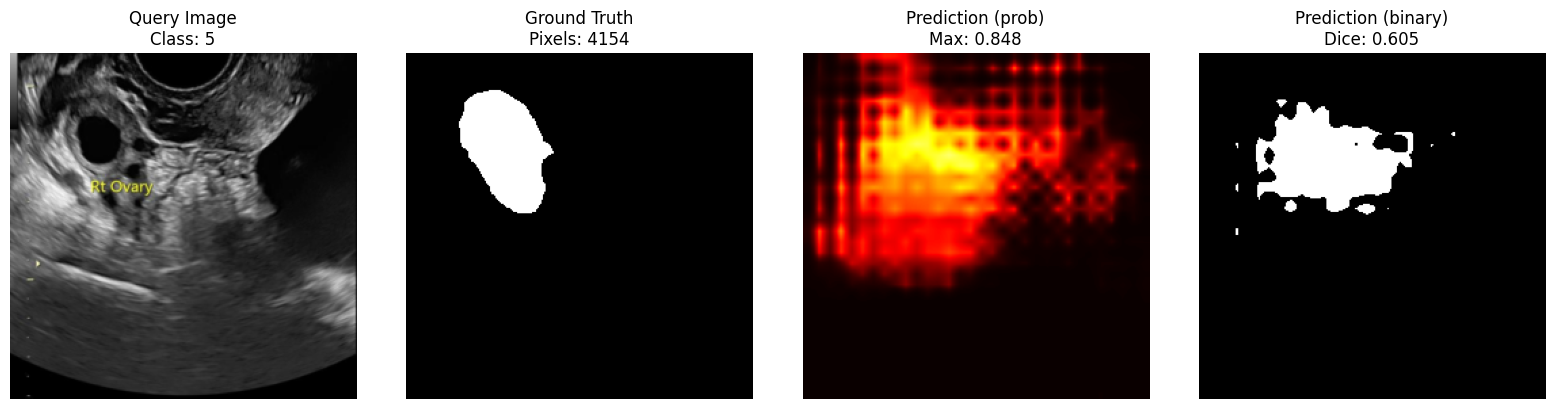

In [10]:
# Quick test with one sample
print("Running quick inference test...")

# Find a test sample with valid mask
test_sample = None
for sample in test_set.samples:
    if sample['mask'].sum() > 100:
        test_sample = sample
        break

if test_sample is not None:
    target_class = test_sample['class']
    print(f"Query class: {target_class}")
    
    # Get support samples
    support_samples = get_best_support_samples(support_pool, target_class, n_shots=1)
    print(f"Number of support samples: {len(support_samples)}")
    
    if len(support_samples) > 0:
        # Run inference
        pred_prob, pred_binary, gt_mask = inference(model, support_samples, test_sample)
        
        # Compute metrics
        metrics = compute_metrics(pred_binary, gt_mask)
        print(f"\nMetrics:")
        print(f"  Dice: {metrics['dice']:.4f}")
        print(f"  IoU: {metrics['iou']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        
        # Visualize
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        
        # Query image
        img_show = test_sample['image'].transpose(1, 2, 0)
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min() + 1e-8)
        axes[0].imshow(img_show)
        axes[0].set_title(f"Query Image\nClass: {target_class}")
        axes[0].axis('off')
        
        # Ground truth
        axes[1].imshow(gt_mask.cpu().numpy(), cmap='gray')
        axes[1].set_title(f"Ground Truth\nPixels: {gt_mask.sum():.0f}")
        axes[1].axis('off')
        
        # Prediction probability
        axes[2].imshow(pred_prob.cpu().numpy(), cmap='hot', vmin=0, vmax=1)
        axes[2].set_title(f"Prediction (prob)\nMax: {pred_prob.max():.3f}")
        axes[2].axis('off')
        
        # Binary prediction
        axes[3].imshow(pred_binary.cpu().numpy(), cmap='gray')
        axes[3].set_title(f"Prediction (binary)\nDice: {metrics['dice']:.3f}")
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No support samples found for class {target_class}")
else:
    print("No valid test sample found!")

## 8. Evaluation: Metrics by Number of Shots (N)

In [11]:
# ================== EVALUATE BY N-SHOT ==================
print("=" * 80)
print("EVALUATING SSL_ALPNet ON OTU2D - METRICS BY N-SHOT")
print("=" * 80)

N_SHOTS_LIST = [1, 2, 4, 8, 16]
NUM_TEST_SAMPLES = min(469, len(test_set))  # Limit for speed

results_by_N = {N: {'dice': [], 'iou': [], 'precision': [], 'recall': []} for N in N_SHOTS_LIST}

print(f"\nEvaluating on {NUM_TEST_SAMPLES} test samples...")

for idx in tqdm(range(NUM_TEST_SAMPLES), desc="Evaluating"):
    query_sample = test_set[idx]
    target_class = query_sample['class']
    
    # Skip if mask too small
    if query_sample['mask'].sum() < 10:
        continue
    
    for N in N_SHOTS_LIST:
        support_samples = get_best_support_samples(support_pool, target_class, N)
        
        if len(support_samples) == 0:
            continue
        
        try:
            pred_prob, pred_binary, gt_mask = inference(model, support_samples, query_sample)
            metrics = compute_metrics(pred_binary, gt_mask)
            
            for key in metrics:
                results_by_N[N][key].append(metrics[key])
        except Exception as e:
            print(f"Error at idx {idx}, N={N}: {e}")
            continue

# Compute averages
avg_results = []
for N in N_SHOTS_LIST:
    row = {'N': N}
    for metric in ['dice', 'iou', 'precision', 'recall']:
        values = results_by_N[N][metric]
        row[metric] = np.mean(values) if values else 0
        row[f'{metric}_std'] = np.std(values) if values else 0
        row[f'{metric}_count'] = len(values)
    avg_results.append(row)

df_avg = pd.DataFrame(avg_results)

# Display results
print("\n" + "=" * 80)
print("RESULTS BY N-SHOT:")
print("=" * 80)
print(f"\n{'N':>4} | {'#Samples':>8} | {'Dice':>14} | {'IoU':>14} | {'Precision':>14} | {'Recall':>14}")
print("-" * 80)
for _, row in df_avg.iterrows():
    print(f"{int(row['N']):>4} | {int(row['dice_count']):>8} | "
          f"{row['dice']:.4f}±{row['dice_std']:.3f} | "
          f"{row['iou']:.4f}±{row['iou_std']:.3f} | "
          f"{row['precision']:.4f}±{row['precision_std']:.3f} | "
          f"{row['recall']:.4f}±{row['recall_std']:.3f}")

EVALUATING SSL_ALPNet ON OTU2D - METRICS BY N-SHOT

Evaluating on 469 test samples...


Evaluating: 100%|██████████| 469/469 [04:10<00:00,  1.87it/s]


RESULTS BY N-SHOT:

   N | #Samples |           Dice |            IoU |      Precision |         Recall
--------------------------------------------------------------------------------
   1 |      469 | 0.3342±0.244 | 0.2276±0.186 | 0.4250±0.306 | 0.4607±0.350
   2 |      469 | 0.4020±0.238 | 0.2804±0.195 | 0.4298±0.288 | 0.5421±0.318
   4 |      469 | 0.4450±0.231 | 0.3155±0.200 | 0.4427±0.280 | 0.6226±0.290
   8 |      469 | 0.4816±0.230 | 0.3477±0.204 | 0.4584±0.270 | 0.6743±0.266
  16 |      469 | 0.5157±0.233 | 0.3804±0.213 | 0.4592±0.261 | 0.7450±0.247


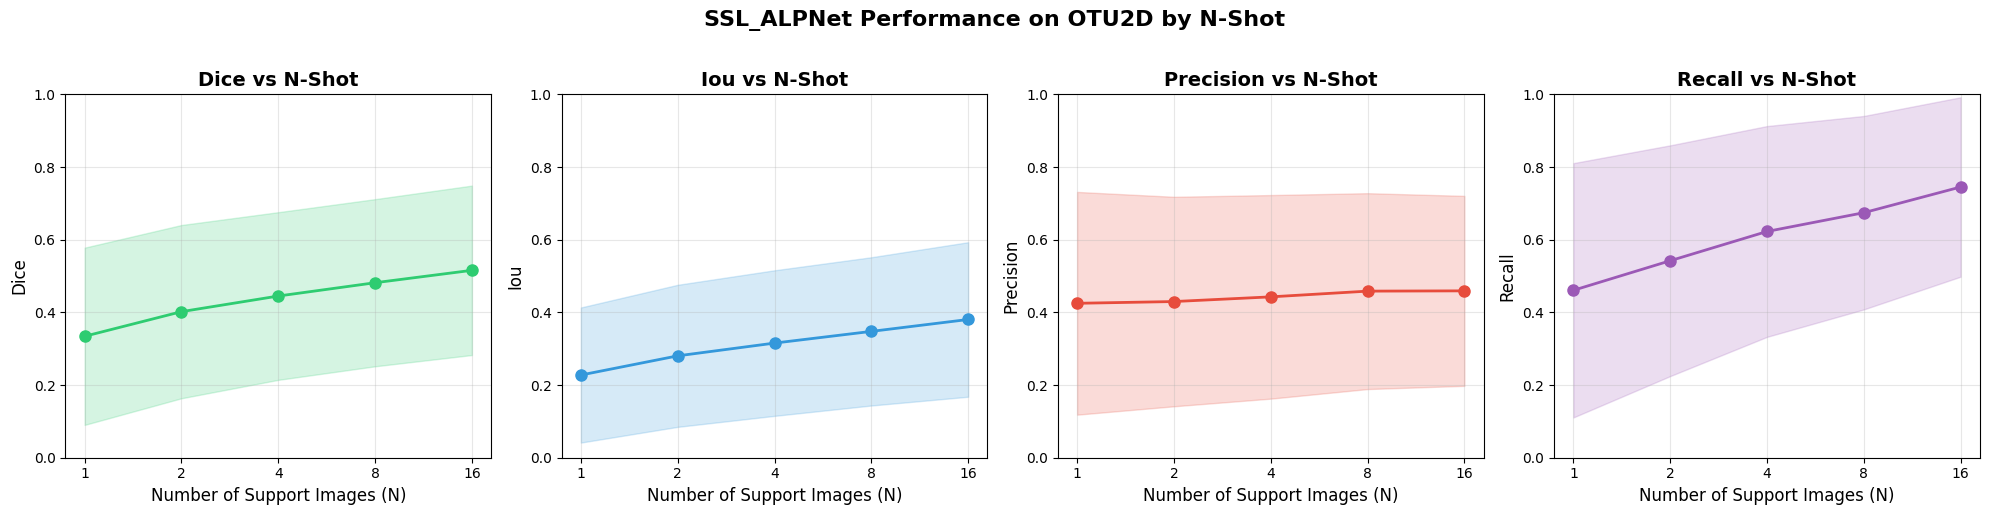


✅ Results saved to ssl_alpnet_metrics_by_N.png


In [12]:
# Plot results
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
metrics_names = ['dice', 'iou', 'precision', 'recall']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for ax, metric, color in zip(axes, metrics_names, colors):
    means = df_avg[metric].values
    stds = df_avg[f'{metric}_std'].values
    
    ax.plot(N_SHOTS_LIST, means, 'o-', color=color, linewidth=2, markersize=8)
    ax.fill_between(N_SHOTS_LIST, means - stds, means + stds, alpha=0.2, color=color)
    ax.set_xlabel('Number of Support Images (N)', fontsize=12)
    ax.set_ylabel(metric.capitalize(), fontsize=12)
    ax.set_title(f'{metric.capitalize()} vs N-Shot', fontsize=14, fontweight='bold')
    ax.set_xscale('log', base=2)
    ax.set_xticks(N_SHOTS_LIST)
    ax.set_xticklabels(N_SHOTS_LIST)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

plt.suptitle('SSL_ALPNet Performance on OTU2D by N-Shot', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ssl_alpnet_metrics_by_N.png', dpi=200, bbox_inches='tight')
plt.show()

print("\n✅ Results saved to ssl_alpnet_metrics_by_N.png")

## 9. Evaluation: Per-Class Metrics

In [13]:
# ================== EVALUATE PER CLASS ==================
N_SELECTED = 8  # Number of shots to use
NUM_SAMPLES_PER_CLASS = 30

print("=" * 80)
print(f"EVALUATING SSL_ALPNet ON OTU2D - PER CLASS METRICS (N={N_SELECTED})")
print("=" * 80)

class_metrics = {c: {'dice': [], 'iou': [], 'precision': [], 'recall': [], 'count': 0} 
                 for c in range(NUM_CLASSES)}

for idx in tqdm(range(len(test_set)), desc="Evaluating"):
    query_sample = test_set[idx]
    cls_idx = query_sample['class']
    
    if query_sample['mask'].sum() <= 10:
        continue
    
    if class_metrics[cls_idx]['count'] >= NUM_SAMPLES_PER_CLASS:
        continue
    
    support_samples = get_best_support_samples(support_pool, cls_idx, N_SELECTED)
    
    if len(support_samples) == 0:
        continue
    
    try:
        pred_prob, pred_binary, gt_mask = inference(model, support_samples, query_sample)
        metrics = compute_metrics(pred_binary, gt_mask)
        
        for key in metrics:
            class_metrics[cls_idx][key].append(metrics[key])
        class_metrics[cls_idx]['count'] += 1
    except Exception as e:
        continue

# Create DataFrame
results_per_class = []
for cls_idx in range(NUM_CLASSES):
    if class_metrics[cls_idx]['count'] == 0:
        continue
    
    row = {
        'Class': cls_idx,
        'Name': LABEL_NAMES[cls_idx],
        'Samples': class_metrics[cls_idx]['count'],
        'Dice': np.mean(class_metrics[cls_idx]['dice']),
        'Dice_std': np.std(class_metrics[cls_idx]['dice']),
        'IoU': np.mean(class_metrics[cls_idx]['iou']),
        'Precision': np.mean(class_metrics[cls_idx]['precision']),
        'Recall': np.mean(class_metrics[cls_idx]['recall']),
    }
    results_per_class.append(row)

df_class = pd.DataFrame(results_per_class)

# Display
print("\n" + "=" * 90)
print(f"PER-CLASS RESULTS (N = {N_SELECTED}):")
print("=" * 90)
print(f"\n{'Class':>6} | {'Name':>12} | {'#Samples':>8} | {'Dice':>10} | {'IoU':>10} | {'Precision':>10} | {'Recall':>10}")
print("-" * 90)

for _, row in df_class.iterrows():
    print(f"{int(row['Class']):>6} | {row['Name']:>12} | {int(row['Samples']):>8} | "
          f"{row['Dice']:.4f}     | {row['IoU']:.4f}     | {row['Precision']:.4f}     | {row['Recall']:.4f}")

# Average
print("-" * 90)
print(f"{'AVG':>6} | {'':>12} | {df_class['Samples'].sum():>8} | "
      f"{df_class['Dice'].mean():.4f}     | {df_class['IoU'].mean():.4f}     | "
      f"{df_class['Precision'].mean():.4f}     | {df_class['Recall'].mean():.4f}")

EVALUATING SSL_ALPNet ON OTU2D - PER CLASS METRICS (N=8)


Evaluating: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


PER-CLASS RESULTS (N = 8):

 Class |         Name | #Samples |       Dice |        IoU |  Precision |     Recall
------------------------------------------------------------------------------------------
     0 |      Class 0 |       30 | 0.4474     | 0.3179     | 0.3724     | 0.7527
     1 |      Class 1 |       30 | 0.6202     | 0.4826     | 0.6404     | 0.6532
     2 |      Class 2 |       30 | 0.4711     | 0.3263     | 0.4855     | 0.5850
     3 |      Class 3 |       30 | 0.5107     | 0.3781     | 0.4684     | 0.7008
     4 |      Class 4 |       19 | 0.4608     | 0.3469     | 0.5324     | 0.5831
     5 |      Class 5 |       30 | 0.3096     | 0.2000     | 0.2363     | 0.6188
     6 |      Class 6 |       30 | 0.6178     | 0.4760     | 0.6617     | 0.6387
     7 |      Class 7 |       15 | 0.5151     | 0.3673     | 0.4316     | 0.7841
------------------------------------------------------------------------------------------
   AVG |              |      214 | 0.4941     | 0.3619  

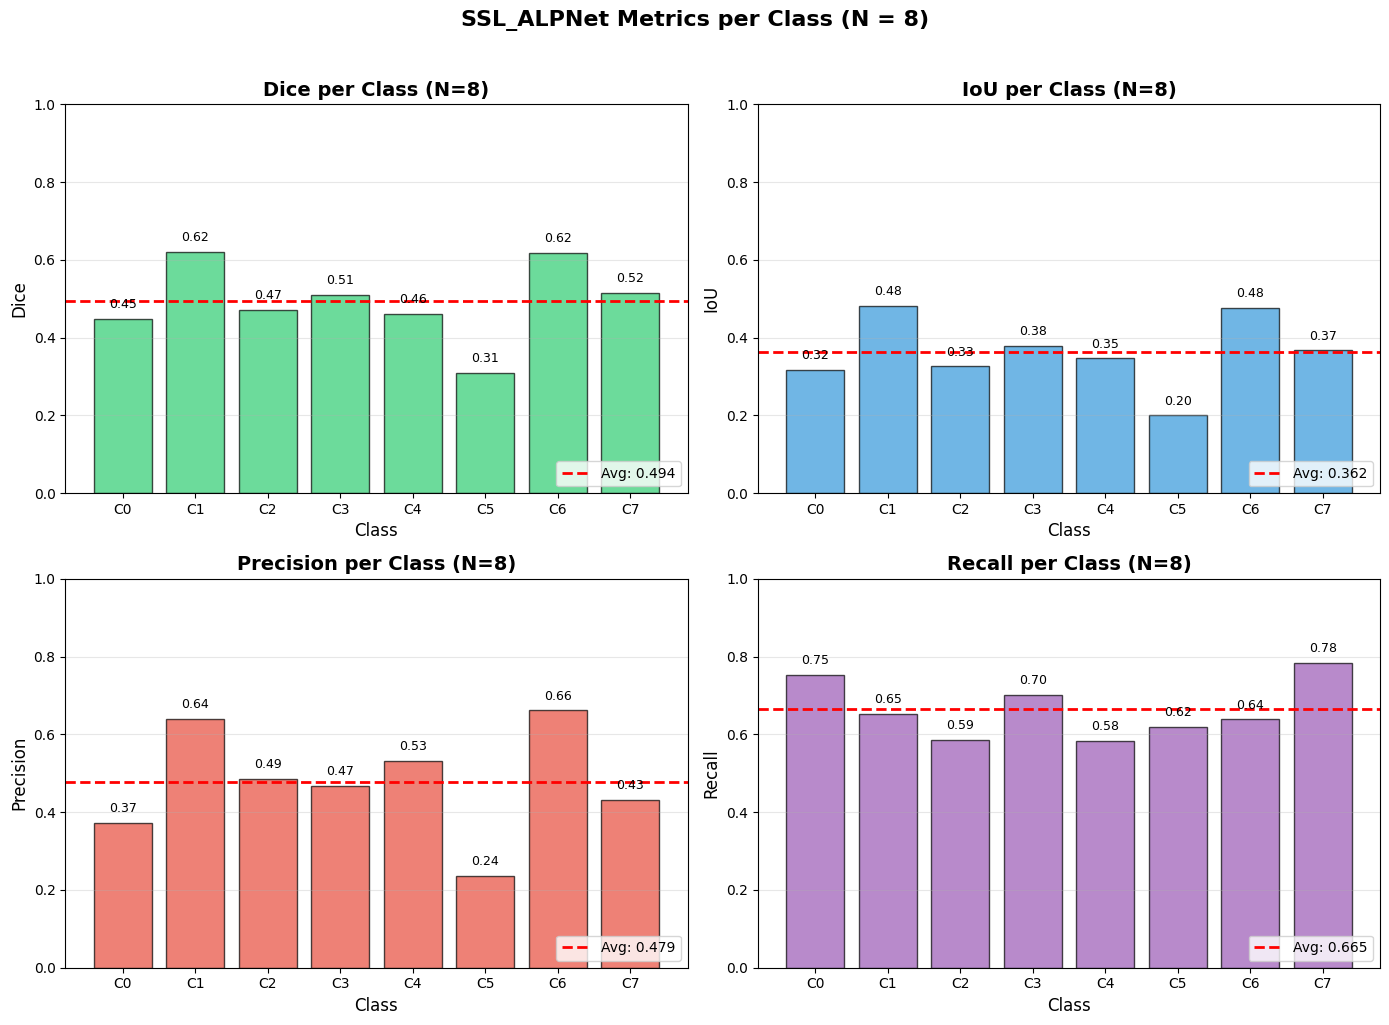


✅ Results saved to ssl_alpnet_metrics_per_class_N8.png


In [14]:
# Plot per-class results
if len(df_class) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics_to_plot = ['Dice', 'IoU', 'Precision', 'Recall']
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

    for ax, metric, color in zip(axes.flatten(), metrics_to_plot, colors):
        x = np.arange(len(df_class))
        values = df_class[metric].values
        
        bars = ax.bar(x, values, color=color, alpha=0.7, edgecolor='black')
        ax.set_xticks(x)
        ax.set_xticklabels([f"C{int(c)}" for c in df_class['Class']], fontsize=10)
        ax.set_xlabel('Class', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(f'{metric} per Class (N={N_SELECTED})', fontsize=14, fontweight='bold')
        ax.axhline(y=df_class[metric].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Avg: {df_class[metric].mean():.3f}')
        ax.legend(loc='lower right')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3, axis='y')
        
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    f'{val:.2f}', ha='center', va='bottom', fontsize=9)

    plt.suptitle(f'SSL_ALPNet Metrics per Class (N = {N_SELECTED})', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(f'ssl_alpnet_metrics_per_class_N{N_SELECTED}.png', dpi=200, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Results saved to ssl_alpnet_metrics_per_class_N{N_SELECTED}.png")
else:
    print("No results to plot!")

## 10. Visualization Grid

Creating visualization grid...
Found 8 samples to visualize


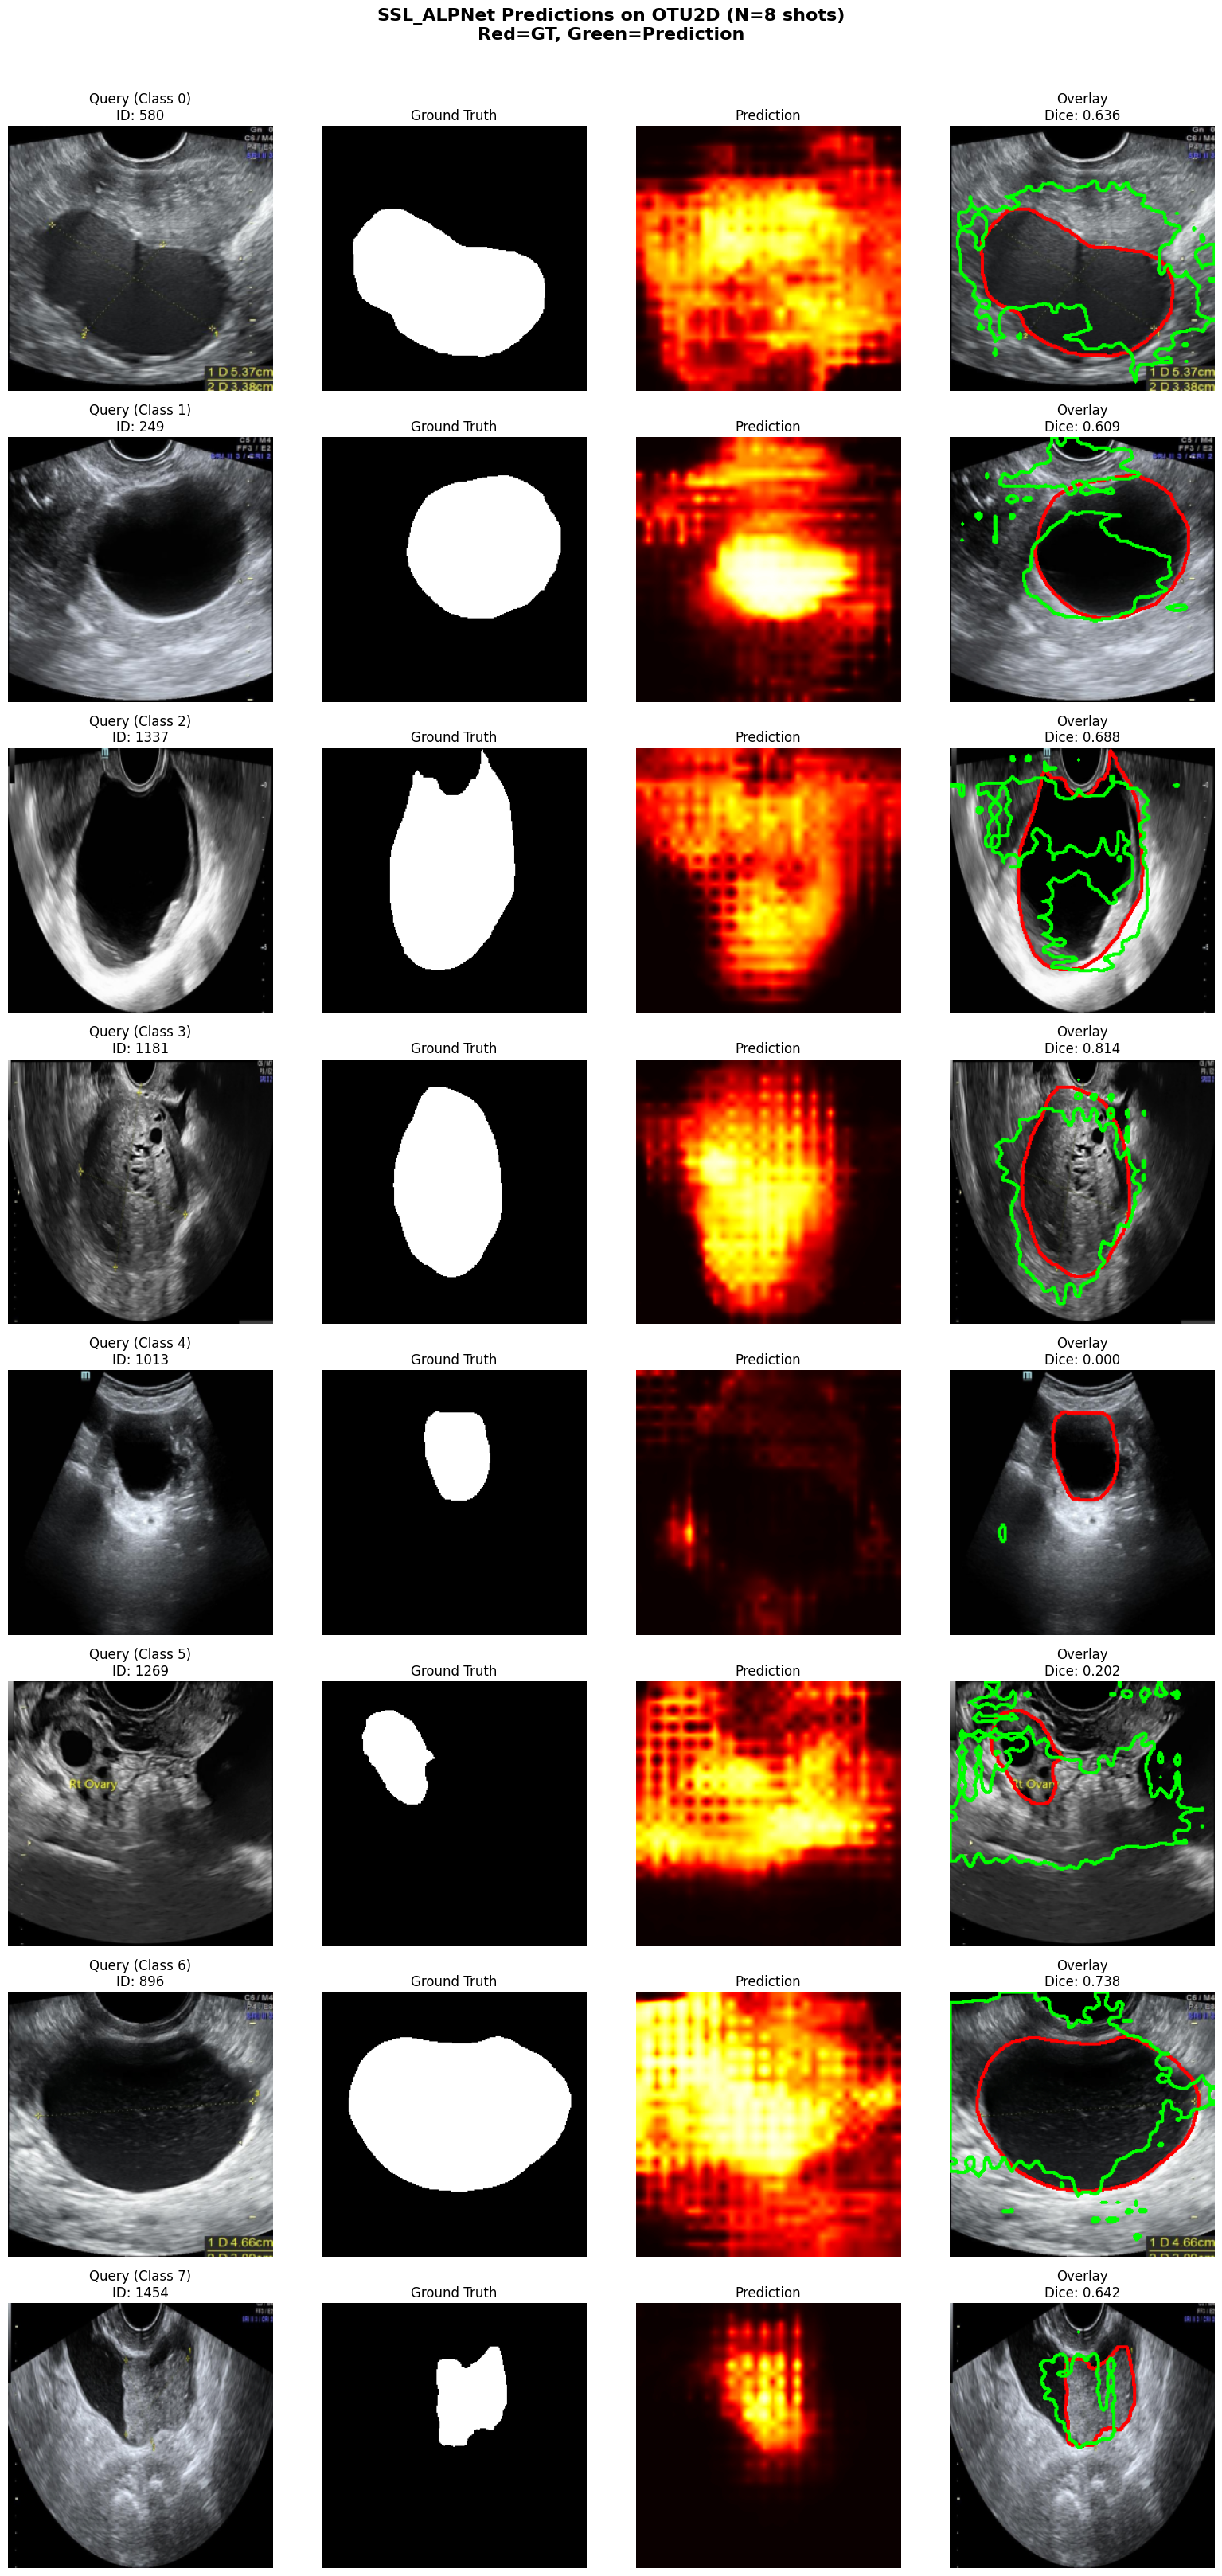


✅ Visualization saved to ssl_alpnet_visualization_grid.png


In [15]:
# ================== VISUALIZATION GRID ==================
print("Creating visualization grid...")

N_VIS = 8  # Number of shots for visualization

# Specific images for each class
target_images = {
    0: '580',
    1: '249',
    2: '1337',
    3: '1181',
    4: '1013',
    5: '1269',
    6: '896',
    7: '1454'
}

# Find samples by ID
samples_to_visualize = []
for target_class, img_id in target_images.items():
    query_sample = None
    for sample in test_set.samples:
        if sample['id'] == img_id and sample['class'] == target_class:
            query_sample = sample
            break
    
    if query_sample is not None:
        samples_to_visualize.append(query_sample)
    else:
        print(f"⚠️ Warning: Could not find image {img_id}.jpg for class {target_class}")

NUM_SAMPLES = len(samples_to_visualize)
print(f"Found {NUM_SAMPLES} samples to visualize")

fig, axes = plt.subplots(NUM_SAMPLES, 4, figsize=(16, 4 * NUM_SAMPLES))

for sample_count, query_sample in enumerate(samples_to_visualize):
    target_class = query_sample['class']
    support_samples = get_best_support_samples(support_pool, target_class, N_VIS)
    
    if len(support_samples) == 0:
        print(f"⚠️ No support samples for class {target_class}")
        continue
    
    try:
        pred_prob, pred_binary, gt_mask = inference(model, support_samples, query_sample)
        metrics = compute_metrics(pred_binary, gt_mask)
        
        # Query image
        img_show = query_sample['image'].transpose(1, 2, 0)
        img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min() + 1e-8)
        
        axes[sample_count, 0].imshow(img_show)
        axes[sample_count, 0].set_title(f"Query (Class {target_class})\nID: {query_sample['id']}")
        axes[sample_count, 0].axis('off')
        
        # Ground truth
        axes[sample_count, 1].imshow(gt_mask.cpu().numpy(), cmap='gray')
        axes[sample_count, 1].set_title(f"Ground Truth")
        axes[sample_count, 1].axis('off')
        
        # Prediction
        axes[sample_count, 2].imshow(pred_prob.cpu().numpy(), cmap='hot', vmin=0, vmax=1)
        axes[sample_count, 2].set_title(f"Prediction")
        axes[sample_count, 2].axis('off')
        
        # Overlay
        overlay = (img_show * 255).astype(np.uint8)
        gt_np = gt_mask.cpu().numpy()
        pred_np = pred_binary.cpu().numpy()
        
        # Draw contours
        gt_contours, _ = cv2.findContours((gt_np > 0.5).astype(np.uint8), 
                                           cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        pred_contours, _ = cv2.findContours((pred_np > 0.5).astype(np.uint8), 
                                             cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        overlay_rgb = cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)
        cv2.drawContours(overlay_rgb, gt_contours, -1, (0, 0, 255), 2)  # Red for GT
        cv2.drawContours(overlay_rgb, pred_contours, -1, (0, 255, 0), 2)  # Green for Pred
        overlay_rgb = cv2.cvtColor(overlay_rgb, cv2.COLOR_BGR2RGB)
        
        axes[sample_count, 3].imshow(overlay_rgb)
        axes[sample_count, 3].set_title(f"Overlay\nDice: {metrics['dice']:.3f}")
        axes[sample_count, 3].axis('off')
        
    except Exception as e:
        print(f"Error visualizing class {target_class}, ID {query_sample['id']}: {e}")
        continue

plt.suptitle(f'SSL_ALPNet Predictions on OTU2D (N={N_VIS} shots)\nRed=GT, Green=Prediction', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('ssl_alpnet_visualization_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved to ssl_alpnet_visualization_grid.png")

## 11. Summary

In [27]:
print("=" * 80)
print("📊 SSL_ALPNet EVALUATION SUMMARY ON OTU2D")
print("=" * 80)

print(f"\n🔧 Configuration:")
print(f"   Model: FewShotSeg (SSL_ALPNet)")
print(f"   Backbone: DeepLabV3-ResNet101")
print(f"   Image size: {RESIZE_TO}")
print(f"   Validation window size: {VAL_WSIZE}")

print(f"\n📁 Dataset:")
print(f"   Support pool: {len(support_pool)} samples")
print(f"   Test set: {len(test_set)} samples")
print(f"   Number of classes: {NUM_CLASSES}")

if len(df_avg) > 0:
    best_N = df_avg.loc[df_avg['dice'].idxmax()]
    print(f"\n🏆 Best N-shot result:")
    print(f"   N = {int(best_N['N'])}")
    print(f"   Dice: {best_N['dice']:.4f}")
    print(f"   IoU: {best_N['iou']:.4f}")

if len(df_class) > 0:
    print(f"\n📈 Per-class summary (N={N_SELECTED}):")
    print(f"   Average Dice: {df_class['Dice'].mean():.4f}")
    print(f"   Average IoU: {df_class['IoU'].mean():.4f}")
    print(f"   Best class: {df_class.loc[df_class['Dice'].idxmax(), 'Name']} "
          f"(Dice={df_class['Dice'].max():.4f})")
    print(f"   Worst class: {df_class.loc[df_class['Dice'].idxmin(), 'Name']} "
          f"(Dice={df_class['Dice'].min():.4f})")

print("\n" + "=" * 80)
print("✅ Evaluation complete!")
print("=" * 80)

📊 SSL_ALPNet EVALUATION SUMMARY ON OTU2D

🔧 Configuration:
   Model: FewShotSeg (SSL_ALPNet)
   Backbone: DeepLabV3-ResNet101
   Image size: (256, 256)
   Validation window size: 2

📁 Dataset:
   Support pool: 1000 samples
   Test set: 469 samples
   Number of classes: 8

🏆 Best N-shot result:
   N = 16
   Dice: 0.5200
   IoU: 0.3826

📈 Per-class summary (N=8):
   Average Dice: 0.5039
   Average IoU: 0.3658
   Best class: Class 1 (Dice=0.6361)
   Worst class: Class 5 (Dice=0.3234)

✅ Evaluation complete!
